In [80]:
%cd '/scratch/sk7898/l3embedding/classifier/sonyc_ust'
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import os
import yaml
import seaborn as sns
import matplotlib as plt
import pickle as pk
import numpy as np
import sklearn
import networkx as nx
import pandas as pd
from classify import get_file_targets, load_embeddings, construct_mlp_mil, construct_mlp_framewise

/scratch/sk7898/l3embedding/classifier/sonyc_ust


In [93]:
version = 'v2.2'
SONYC_PATH = '/scratch/work/sonyc/sonyc/ust/annotations'
EMBS_DIR = '/scratch/sk7898/sonyc_output/embeddings'
DATA_FOLDER = os.path.join('/scratch/sk7898/l3embedding/notebooks/data', version)
taxonomy_path = os.path.join(SONYC_PATH, '{}/dcase-ust-taxonomy.yaml'.format(version))

if version == 'v2.2':
    annotation_path = os.path.join(SONYC_PATH, 'latest/annotations_w_test_anns.csv')
else:
    annotation_path = os.path.join(SONYC_PATH, '{}/annotations.csv'.format(version))

annotation_data = pd.read_csv(annotation_path).sort_values('audio_filename')
annotation_data = annotation_data[annotation_data['annotator_id'] == 0]

with open(taxonomy_path, 'r') as f:
    taxonomy = yaml.load(f, Loader=yaml.Loader)
        
coarse_target_labels = ["_".join([str(k), v]) for k, v in taxonomy['coarse'].items()]
coarse_target_list = get_file_targets(annotation_data, coarse_target_labels)

In [86]:
target_labels = [
     'engine',
     'machinery-impact',
     'non-machinery-impact',
     'powered-saw',
     'alert-signal',
     'music',
     'human-voice',
     'dog']

In [102]:
one_cls_idxs = np.count_nonzero(coarse_target_list==1, axis=1) == 1
one_cls_targets = coarse_target_list[one_cls_idxs]
one_cls_files = np.array(annotation_data['audio_filename'])[one_cls_idxs]

per_cls_counts = np.count_nonzero(one_cls_targets==1, axis=0)
for l, c in zip(target_labels, per_cls_counts):
    print('{}:{}'.format(l, c))

engine:159
machinery-impact:17
non-machinery-impact:9
powered-saw:20
alert-signal:50
music:10
human-voice:139
dog:7


In [83]:
cls_type = 'mlp'
emb_dir = os.path.join(EMBS_DIR, version, 'features/sonyc_ust/l3/melSpec_20200304183233_48000_256_242_2048')
cls_path = os.path.join(EMBS_DIR, version, 'classifier/sonyc_ust/{}/melSpec_20200304183233_48000_256_242_2048/0_0/results'.format(cls_type))

embeddings = load_embeddings(one_cls_files, emb_dir)

scaler_path = os.path.join(cls_path, 'stdizer.pkl')
scaler = pk.load(open(scaler_path,'rb'), encoding='utf-8')
embeddings = np.array([scaler.transform(emb) for emb in embeddings])

/scratch/sk7898/miniconda3/envs/l3embedding-tf-2-gpu/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.0 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [84]:
_, num_frames, emb_size = embeddings.shape

model_weight_file = os.path.join(cls_path, 'model_best.h5')
model = construct_mlp_framewise(emb_size, num_classes=8, sensor_factor=False, proximity_factor=False)
model.load_weights(model_weight_file)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 512)               0         
_________________________________________________________________
output (Dense)               (None, 8)                 4104      
Total params: 4,104
Trainable params: 4,104
Non-trainable params: 0
_________________________________________________________________
None


In [85]:
prototypes = np.zeros((one_cls_targets.shape[1], emb_size), dtype=np.float32)
row_list = []
for cls in range(one_cls_targets.shape[1]):
    per_cls_idxs = one_cls_targets[:, cls] == 1 
    cls_files = one_cls_files[per_cls_idxs]
    cls_mean_emb = np.zeros((len(per_cls_idxs), emb_size), dtype=np.float32)
    for i, (emb, audio_file) in enumerate(zip(embeddings[per_cls_idxs], one_cls_files[per_cls_idxs])):
        pred = model.predict(emb) #shape: (91, 8)
        frame_idx = np.argmax(pred[:, cls])
        cls_mean_emb[i, :] = emb[frame_idx]
        row_list.append([coarse_target_labels[cls], audio_file, frame_idx, pred[frame_idx, cls]])
    prototypes[cls, :] = np.mean(cls_mean_emb, axis=0)

output_path = os.path.join(DATA_FOLDER, 'frames_for_viz.csv')
df = pd.DataFrame(row_list, columns = ['coarse_label', 'audio_filename', 'frame_idx', 'softmax_confidence']) 
df.to_csv(output_path, index=False)

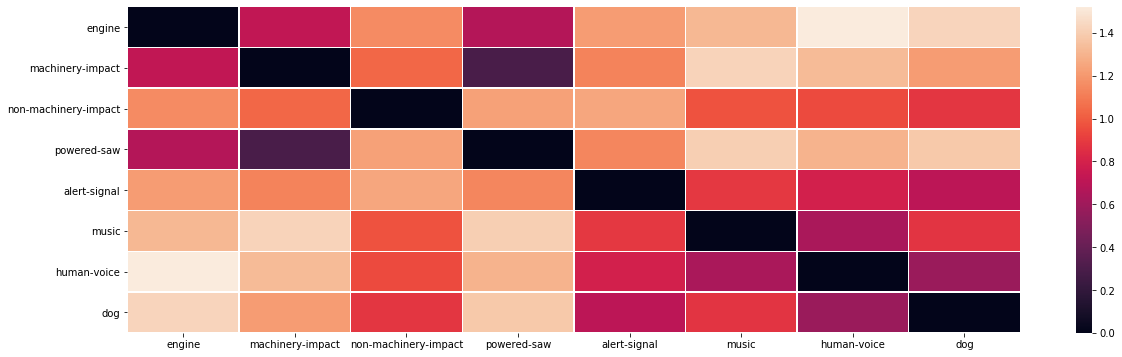

In [87]:
dist = sklearn.metrics.pairwise_distances(prototypes, Y=None, metric='cosine')
ax = sns.heatmap(dist, xticklabels=target_labels, yticklabels=target_labels, linewidth=0.5)

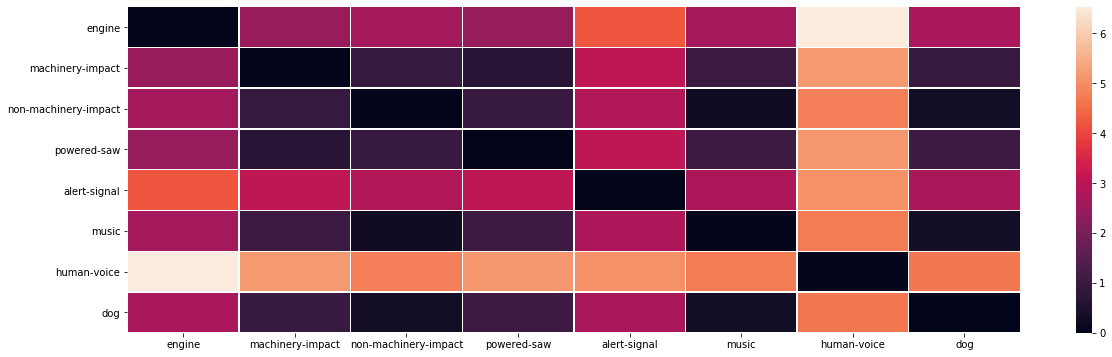

In [88]:
dist = sklearn.metrics.pairwise_distances(prototypes, Y=None, metric='euclidean')
ax = sns.heatmap(dist, xticklabels=target_labels, yticklabels=target_labels, linewidth=0.5)

In [79]:
np.savetxt("dist.csv", dist, delimiter=",")

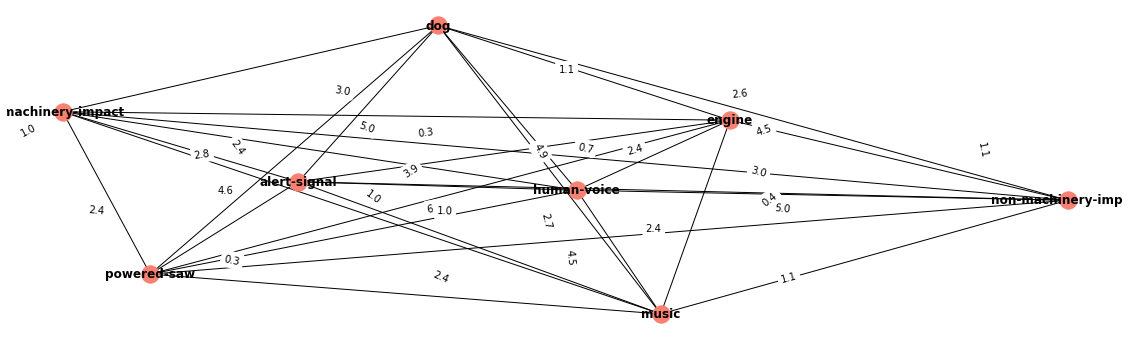

In [61]:
plt.rcParams["figure.figsize"] = (20, 6)
G = nx.Graph()
for i in range(dist.shape[0]):
    for j in range(dist.shape[0]):
        if i != j:
            G.add_edge(i, j, weight=dist[i][j])

G = nx.relabel_nodes(G, dict(zip(range(len(G.nodes())), target_labels)))
labels = nx.get_edge_attributes(G,'weight')
for k in labels.keys():
    labels[k] = round(labels[k], 1)
nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G), edge_labels=labels)

nx.draw(G, with_labels=True, pos=nx.spring_layout(G), font_weight='bold', node_color='salmon')